In [7]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import numpy as np
from tqdm import tqdm
import scipy.stats as stats
import itertools

In [2]:
## Matplotlib defaults ##
colors = {"5": "#aa0f35", 
         "6": "#fdc799",
         "7": "#a0a75c",
         "8": "#603734",
         "9": "#abdbfc",
         "10": "#313a61",
         "15": "#bfbad5",
         "20": "#f89b00"}

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rcParams.update({'font.size': 22})

# Overview

Analyze assembly index calculations across patent data. These calculations are from random samples of compounds present in each month from 1980-2019.

//TODO: sample from new compounds added in each month

In [3]:
fp = "Data/AssemblyValues/assembly_values_1000_1980.p"
assembly_values = pickle.load(file=open(fp, "rb"))

In [4]:
print(assembly_values[100:199])

[{'month': '1980-01', 'inchi': 'InChI=1S/C17H35Cl.H3N/c1-5-6-7-8-9-10-11-12-13-14-15-16(2)17(3,4)18;/h16H,5-15H2,1-4H3;1H3', 'ai': 16}, {'month': '1980-01', 'inchi': 'InChI=1S/C27H33P/c1-16-10-25(11-17(2)22(16)7)28(26-12-18(3)23(8)19(4)13-26)27-14-20(5)24(9)21(6)15-27/h10-15H,1-9H3', 'ai': 14}, {'month': '1980-01', 'inchi': 'InChI=1S/C27H33P/c1-7-22-10-19(4)13-25(16-22)28(26-14-20(5)11-23(8-2)17-26)27-15-21(6)12-24(9-3)18-27/h10-18H,7-9H2,1-6H3', 'ai': 16}, {'month': '1980-01', 'inchi': 'InChI=1S/C30H39P/c1-28(2,3)22-13-10-16-25(19-22)31(26-17-11-14-23(20-26)29(4,5)6)27-18-12-15-24(21-27)30(7,8)9/h10-21H,1-9H3', 'ai': 20}, {'month': '1980-01', 'inchi': 'InChI=1S/C18H31N/c1-2-3-4-5-15-6-10-17(11-7-15)18-12-8-16(14-19)9-13-18/h15-18H,2-13H2,1H3', 'ai': 9}, {'month': '1980-01', 'inchi': 'InChI=1S/C16H17NO2/c18-16(19)14-10-4-5-11-15(14)17-12-6-9-13-7-2-1-3-8-13/h1-5,7-8,10-11,17H,6,9,12H2,(H,18,19)', 'ai': 14}, {'month': '1980-01', 'inchi': 'InChI=1S/C20H32O2/c1-12-10-14(21)11-13-4-5-15-16

In [3]:
def build_month_increments(start, stop):
    """ Build all monthly increments from the start year to stop year in the
    format YEAR-MONTH

    Args:
        start (int): start year of increments
        stop (int): end year of increments

    Returns:
        list: list of strings holding the YEAR-MONTH increments
    """
    months = []
    while start <= stop:
        for month in [
                "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
                "11", "12"
        ]:
            months.append(str(start) + "-" + month)
        start += 1

    return months

In [12]:
months = build_month_increments(1980, 1980)
print(months)

['1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06', '1980-07', '1980-08', '1980-09', '1980-10', '1980-11', '1980-12']


# New / Total Compound Assemblies

There are varying numbers of compounds for each month - so it's necessary to make separate lists for each month. These are stored in a dictionary {month: [assembly values]}

In [23]:
#Create a dictionary of months & assembly indices
new_month_ais = {} 


#Full function for many-year analysis
for year in tqdm(range(1980,2007)):
    #Build months associated with each year
    months = build_month_increments(year, year)
    
    #Add AI for each month
    for month in months:
        ###Uncomment when all years are finished on Agave
#         ais = []
        
#         #Load assembly values - full and new
#         fp = "Data/AssemblyValues/assembly_values_1000_FULL_" + str(year) + ".p"
#         assembly_values = pickle.load(file=open(fp, "rb"))
        
#         for cpd in assembly_values:
#             if cpd["month"] == month:
#                 ais.append(cpd["ai"])

#         full_month_ais[month] = ais
        
        ais = []
        fp = "Data/AssemblyValues/assembly_values_1000_" + str(year) + ".p"
        assembly_values = pickle.load(file=open(fp, "rb"))
        
        for cpd in assembly_values:
            if cpd["month"] == month:
                ais.append(cpd["ai"])

        new_month_ais[month] = ais

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.42it/s]


In [24]:
#Add extra years (only needed when assembly values are still being calculated)
full_month_ais = {}
for year in tqdm(range(1980, 2013)):
    #Build months associated with each year
    months = build_month_increments(year, year)
    
    #Add AI for each month
    for month in months:
        ais = []
        
        #Load assembly values - full and new
        fp = "Data/AssemblyValues/assembly_values_1000_FULL_" + str(year) + ".p"
        assembly_values = pickle.load(file=open(fp, "rb"))
        
        for cpd in assembly_values:
            if cpd["month"] == month:
                ais.append(cpd["ai"])

        full_month_ais[month] = ais

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:07<00:00,  4.23it/s]


In [25]:
#Find average & standard deviation for each month
new_month_avgs = []
new_month_stds = []

for month, ais in new_month_ais.items(): #NOTE: uncomment for new analysis
    new_month_avgs.append(np.mean(ais))
    new_month_stds.append(np.std(ais))


In [26]:
#NOTE: uncomment for full analysis
full_month_avgs = []
full_month_stds = []
for month, ais in full_month_ais.items(): 
    full_month_avgs.append(np.mean(ais))
    full_month_stds.append(np.std(ais))

### Plotting

Plot mean, standard deviation, other data for each month

Text(0, 0.5, 'Assembly Index')

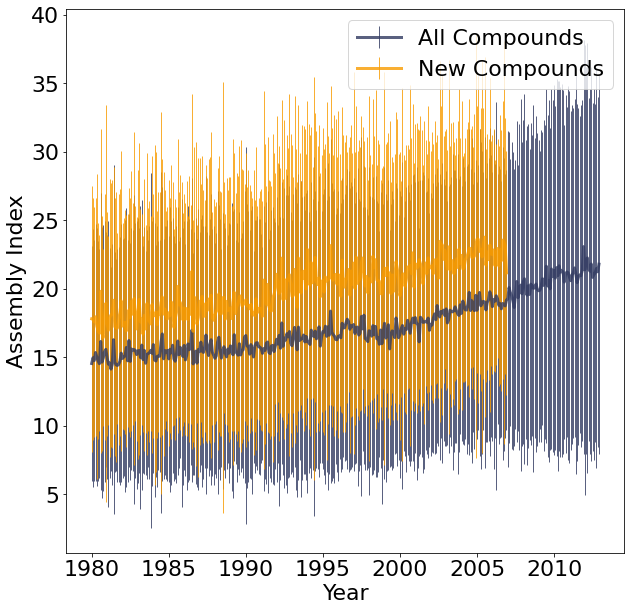

In [38]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))

plt.errorbar(np.arange(1980, 2013, 1/12), full_month_avgs, yerr=full_month_stds, color="#313a61",
            elinewidth=1, linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

plt.errorbar(np.arange(1980, 2007, 1/12), new_month_avgs, yerr=new_month_stds, color="#f89b00",
            elinewidth=1, linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

#plt.axes().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

Text(0, 0.5, 'Assembly Index')

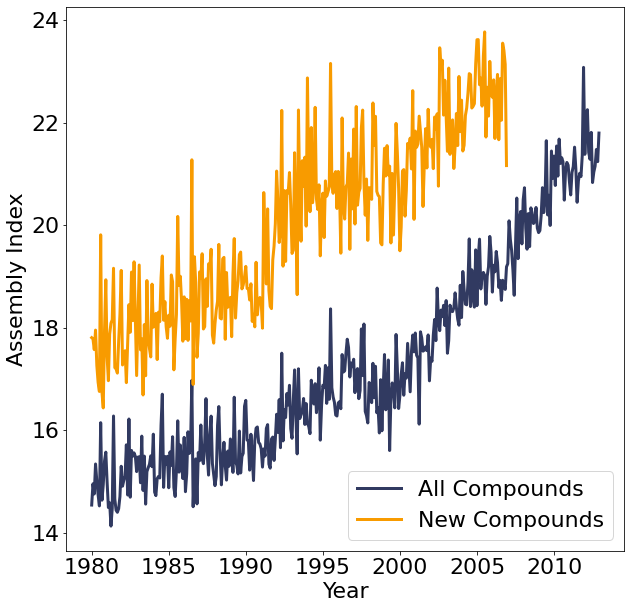

In [34]:
#Assembly values without standard deviation
plt.figure(figsize=(10,10))
plt.plot(np.arange(1980, 2013, 1/12), full_month_avgs, color="#313a61", linewidth=3, label="All Compounds")
plt.plot(np.arange(1980, 2007, 1/12), new_month_avgs, color="#f89b00", linewidth=3, label="New Compounds")

#plt.axes().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

# Changing Compounds Assemblies

Analyze the assembly values of fast-changing (min & max percentiles) compounds

Sets to analyze:
1. Compounds in 99.99th percentile
2. Changing compounds, 99.99th percentile (maxPercentile_0.01_99.99*)
3. Changing compounds, below 0.01st percentile (minPercentile_0.01_99.99*)
4. Changing compounds, 99.9th percentile (maxPercentile_0.1_99.9*)
5. Changing compounds, below 0.1st percentile (minPercentile_0.1_99.9*) 

In [4]:
## Matplotlib defaults ##
colors = {"1980": "#aa0f35", 
         "1985": "#fdc799",
         "1990": "#abdbfc",
         "1995": "#a0a75c",
         "2000": "#603734",
         "2005": "#009ecb",
         "2010": "#430057",
         "2015": "#f89b00"}

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rcParams.update({'font.size': 22})

### Compounds in 99.99th percentile 

Plot & analyze the most connected compounds in SureChemBL

------  (2015, 2019) -----
DescribeResult(nobs=722, minmax=(1, 119), mean=15.637119113573407, variance=256.75579085680477, skewness=3.308937717875287, kurtosis=12.829833350312803)
------  (2010, 2014) -----
DescribeResult(nobs=695, minmax=(1, 119), mean=15.751079136690647, variance=284.97973586548625, skewness=3.264398959689537, kurtosis=11.761944878282671)
------  (2005, 2009) -----
DescribeResult(nobs=540, minmax=(1, 119), mean=17.15, variance=354.5655844155844, skewness=2.748878893799469, kurtosis=7.721047532280789)
------  (2000, 2004) -----
DescribeResult(nobs=265, minmax=(1, 100), mean=16.60377358490566, variance=346.93710691823895, skewness=2.4396828094647396, kurtosis=5.448874109651744)
------  (1995, 1999) -----
DescribeResult(nobs=163, minmax=(2, 87), mean=15.50920245398773, variance=322.7082481254261, skewness=2.2988947899026977, kurtosis=4.296780402120956)
------  (1990, 1994) -----
DescribeResult(nobs=126, minmax=(3, 87), mean=16.73015873015873, variance=393.7986031746031,

Text(0, 0.5, 'Compound Density')

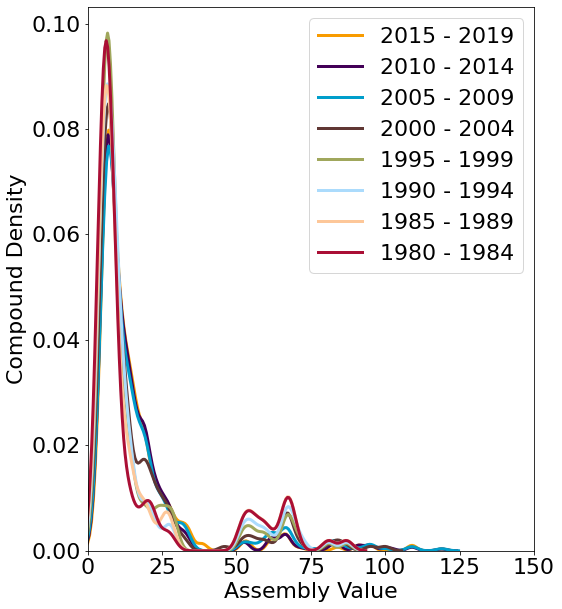

In [48]:
pairs = [(1980, 1984), (1985,1989), (1990,1994), (1995,1999), (2000,2004), (2005,2009), (2010,2014), (2015,2019)]

full_ais = []

plt.figure(figsize=(8,10))

for pair in reversed(pairs):
    print("------ ", pair, "-----")
    start = pair[0]
    stop = pair[1]
    ids = pickle.load(file=open("Data/Cpd_Data/ids_above99_99percentile" + str(start) + "_" + 
                                str(stop) + "cpdData_assembly.p", "rb"))
    
    ais = []
    for cpd in ids:
        ais.append(cpd["ai"])
        
    #Remove -1s
    ais = [x for x in ais if x != -1]
    full_ais.append(ais)

    print(stats.describe(ais))
    
    #plt.hist(ais, bins=100, color=colors[str(start)], label= str(start) + " - " + str(stop))
    sns.kdeplot(ais, bw_method=0.1, color=colors[str(start)], label= str(start) + " - " + str(stop), linewidth=3)

plt.legend()
plt.xlim(0,150)
plt.xlabel("Assembly Value")
plt.ylabel("Compound Density")

In [54]:
combos = itertools.combinations(range(0,len(full_ais)), 2)
for combo in combos:
    print(combo)
    print(stats.ks_2samp(full_ais[combo[0]], full_ais[combo[1]]))
    print(stats.anderson_ksamp([full_ais[combo[0]], full_ais[combo[1]]]))
    print("Wasserstein Distance:", stats.wasserstein_distance(full_ais[combo[0]], full_ais[combo[1]]))
    print()

(0, 1)
KstestResult(statistic=0.011891428685306602, pvalue=0.9999999977077801)
Anderson_ksampResult(statistic=-1.0699860338119844, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 0.5383247972259305

(0, 2)
KstestResult(statistic=0.03345644813788858, pvalue=0.864307761582229)
Anderson_ksampResult(statistic=-0.7580090187166283, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.5986713860675081

(0, 3)
KstestResult(statistic=0.07503789264621336, pvalue=0.21189782394499013)
Anderson_ksampResult(statistic=2.095567746527271, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.044571432106303426)
Wasserstein Distance: 2.4402341504207357

(0, 4)
KstestResult(statistic=0.15266896657206463, pvalue=0.00355205398259939)
Anderson_ksampResult(statistic=7.680779381202069, critical_values=array([0.325, 1.226, 1.961,

c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """
c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value floored: true value smaller than 0.001
  """


Anderson_ksampResult(statistic=9.969150247135532, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
Wasserstein Distance: 4.8081519663993895

(3, 4)
KstestResult(statistic=0.07952309295057298, pvalue=0.5130898912449378)
Anderson_ksampResult(statistic=0.4417356012385059, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.21880182947808205)
Wasserstein Distance: 1.445630281282555

(3, 5)
KstestResult(statistic=0.0746031746031746, pvalue=0.6925072704114961)
Anderson_ksampResult(statistic=0.08146284297910673, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 2.2620545073375258

(3, 6)
KstestResult(statistic=0.10302672955974843, pvalue=0.4094223190343369)
Anderson_ksampResult(statistic=0.4713304271827982, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.21247405604335284)
Wasserstein

### Changing compounds, 99.9th percentile 

------  (2015, 2019) -----
DescribeResult(nobs=255, minmax=(2, 72), mean=10.011764705882353, variance=70.38962482630848, skewness=3.9867883140560094, kurtosis=20.504278861694107)

------  (2010, 2014) -----
DescribeResult(nobs=192, minmax=(2, 72), mean=9.916666666666666, variance=75.68935427574172, skewness=4.255366022937834, kurtosis=22.321515447802124)

------  (2005, 2009) -----
DescribeResult(nobs=44, minmax=(3, 59), mean=11.272727272727273, variance=159.69133192389006, skewness=2.8373976748006977, kurtosis=7.087474216438332)

------  (2000, 2004) -----
DescribeResult(nobs=11, minmax=(5, 28), mean=10.272727272727273, variance=41.41818181818182, skewness=2.0420616823932276, kurtosis=3.4622930639371434)

------  (1995, 1999) -----
DescribeResult(nobs=143, minmax=(2, 72), mean=10.23076923076923, variance=94.27735644637053, skewness=4.001581217375285, kurtosis=18.41325504799777)

------  (1990, 1994) -----
DescribeResult(nobs=193, minmax=(2, 72), mean=9.963730569948186, variance=76.587

Text(0, 0.5, 'Compound Density')

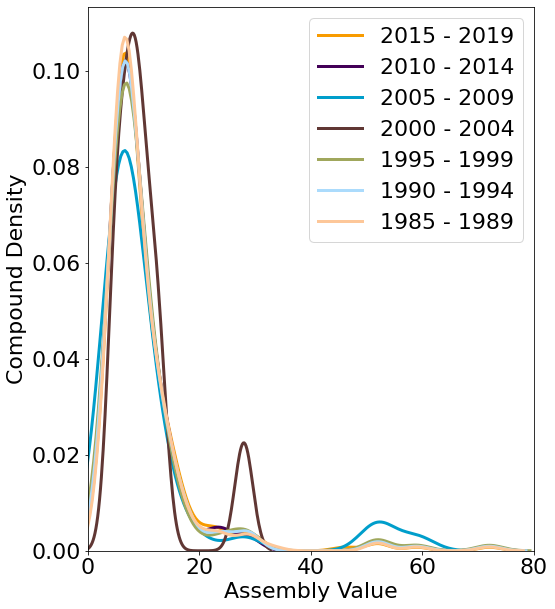

In [49]:
pairs = [(1985,1989), (1990,1994), (1995,1999), (2000,2004), (2005,2009), (2010,2014), (2015,2019)]

full_ais = []

plt.figure(figsize=(8,10))

for pair in reversed(pairs):
    print("------ ", pair, "-----")
    start = pair[0]
    stop = pair[1]
    ids = pickle.load(file=open("Data/Cpd_Data/ids_change_maxPercentile_0.1_99.9_" + str(start-1) + "_" + 
                                str(stop) + "cpdData_assembly.p", "rb"))
    
    ais = []
    for cpd in ids:
        ais.append(cpd["ai"])
        
    #Remove -1s
    ais = [x for x in ais if x != -1]
    full_ais.append(ais)

    print(stats.describe(ais))
    print()
    
    #plt.hist(ais, bins=100, color=colors[str(start)], alpha=0.8, label= str(start-1) + " - " + str(stop))
    sns.kdeplot(ais, bw_method=0.25, color=colors[str(start)], label= str(start) + " - " + str(stop), linewidth=3)
    

plt.legend()
plt.xlim(0,80)
plt.xlabel("Assembly Value")
plt.ylabel("Compound Density")

In [56]:
combos = itertools.combinations(range(0,len(full_ais)), 2)
for combo in combos:
    print(combo)
    print(stats.ks_2samp(full_ais[combo[0]], full_ais[combo[1]]))
    print(stats.anderson_ksamp([full_ais[combo[0]], full_ais[combo[1]]]))
    print("Wasserstein Distance:", stats.wasserstein_distance(full_ais[combo[0]], full_ais[combo[1]]))
    print()

(0, 1)
KstestResult(statistic=0.01997549019607843, pvalue=0.9999999995237022)
Anderson_ksampResult(statistic=-1.2325645468887758, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 0.2848039215686279

(0, 2)
KstestResult(statistic=0.08360071301247772, pvalue=0.9325351708624212)
Anderson_ksampResult(statistic=-0.49182366723549, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 2.154545454545455

(0, 3)
KstestResult(statistic=0.22923351158645278, pvalue=0.5602536950607762)
Anderson_ksampResult(statistic=-0.7006021084284263, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.7283422459893059

(0, 4)
KstestResult(statistic=0.02243246949129302, pvalue=0.9999999981044085)
Anderson_ksampResult(statistic=-1.2121593830680966, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.

c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """


### Changing compounds, below 0.1st percentile 


------  (2015, 2019) -----
DescribeResult(nobs=14, minmax=(5, 23), mean=9.214285714285714, variance=19.719780219780223, skewness=2.2753652312810235, kurtosis=4.823006522592599)

------  (2010, 2014) -----
DescribeResult(nobs=33, minmax=(5, 23), mean=8.181818181818182, variance=11.090909090909088, skewness=2.7821910406362513, kurtosis=9.941764226686384)

------  (2005, 2009) -----
DescribeResult(nobs=151, minmax=(3, 53), mean=9.655629139072847, variance=36.84061810154526, skewness=3.627597139606427, kurtosis=18.859142589807984)

------  (2000, 2004) -----
DescribeResult(nobs=389, minmax=(3, 81), mean=10.352185089974293, variance=39.69265629555031, skewness=4.987640846788539, kurtosis=45.03610802378697)

------  (1995, 1999) -----
DescribeResult(nobs=216, minmax=(3, 53), mean=9.787037037037036, variance=32.43815676141257, skewness=3.3281999121769847, kurtosis=17.82198377577295)

------  (1990, 1994) -----
DescribeResult(nobs=434, minmax=(2, 81), mean=10.264976958525345, variance=42.84186

Text(0, 0.5, 'Compound Density')

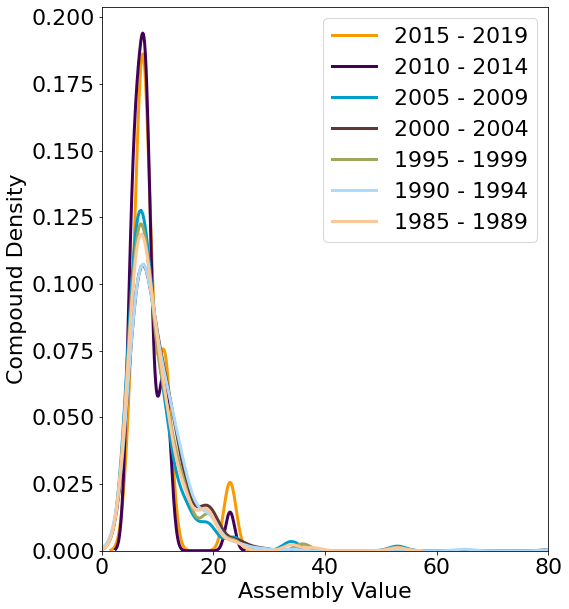

In [50]:
pairs = [(1985,1989), (1990,1994), (1995,1999), (2000,2004), (2005,2009), (2010,2014), (2015,2019)]

full_ais = []

plt.figure(figsize=(8,10))

for pair in reversed(pairs):
    print("------ ", pair, "-----")
    start = pair[0]
    stop = pair[1]
    ids = pickle.load(file=open("Data/Cpd_Data/ids_change_minPercentile_0.1_99.9_" + str(start-1) + "_" + 
                                str(stop) + "cpdData_assembly.p", "rb"))
    
    ais = []
    for cpd in ids:
        ais.append(cpd["ai"])
        
    #Remove -1s
    ais = [x for x in ais if x != -1]
    full_ais.append(ais)

    print(stats.describe(ais))
    print()
    
    #plt.hist(ais, bins=100, color=colors[str(start)], alpha=0.8, label= str(start-1) + " - " + str(stop))
    sns.kdeplot(ais, bw_method=0.25, color=colors[str(start)], label= str(start) + " - " + str(stop), linewidth=3)
    

plt.legend()
plt.xlim(0,80)
plt.xlabel("Assembly Value")
plt.ylabel("Compound Density")

In [58]:
combos = itertools.combinations(range(0,len(full_ais)), 2)
for combo in combos:
    print(combo)
    print(stats.ks_2samp(full_ais[combo[0]], full_ais[combo[1]]))
    print(stats.anderson_ksamp([full_ais[combo[0]], full_ais[combo[1]]]))
    print("Wasserstein Distance:", stats.wasserstein_distance(full_ais[combo[0]], full_ais[combo[1]]))
    print()

(0, 1)
KstestResult(statistic=0.16017316017316016, pvalue=0.9137835326059303)
Anderson_ksampResult(statistic=-0.6886537335030235, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.0324675324675323

(0, 2)
KstestResult(statistic=0.16177861873226113, pvalue=0.8342558375814302)
Anderson_ksampResult(statistic=-0.8290556286861674, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.1556291390728484

(0, 3)
KstestResult(statistic=0.15956665442526624, pvalue=0.8283453243806849)
Anderson_ksampResult(statistic=-0.33110729841668524, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.6972089607051064

(0, 4)
KstestResult(statistic=0.14417989417989419, pvalue=0.9095928141227335)
Anderson_ksampResult(statistic=-0.7078635438065096, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752

c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """
